In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-fahretdinov/Statictics/Dataframes/hw_aa.csv', sep=';')

In [4]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [5]:
# сделаем 2 датафрейма с experimentVariant == 0 и experimentVariant == 1 и у обоих оставим по колонке purchase
# для сравнения двух экспериментов:

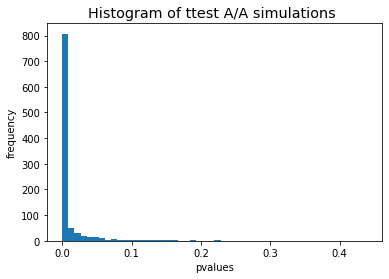

0.932

In [6]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

In [7]:
# видим очевидную поломку в данных по результатам А/А теста

In [8]:
# сгруппируем данные и найдем конверсию (purchase.mean), чтобы выяснить,
# где находятся аномально низкие/высокие показатели данных, которые влияют
# на столь большой FPR:
df.groupby(['experimentVariant','version']).agg({'purchase': 'mean', 'uid': 'count'})
# в version == v2.8.0 варианта 0 конверсия всего 0.000993  - значение сильно ниже, чем в этой же версии варианта 1

purchase    uid
experimentVariant version                  
0                 v2.8.0    0.000993  41283
                  v2.9.0    0.074658  11921
                  v3.7.4.0  0.059943   4204
                  v3.8.0.0  0.057604   5694
1                 v2.8.0    0.045606  41552
                  v2.9.0    0.071304  12033
                  v3.7.4.0  0.063018   4221
                  v3.8.0.0  0.062848   6110

In [9]:
# проведем t-test для всех версий приложения и найдем , где p-value < 0.05.
# для этого преобработаем данные:
v2_8 = df.query("version == 'v2.8.0' & experimentVariant == 0")
v2_81 = df.query("version == 'v2.8.0' & experimentVariant == 1")

v2_9 = df.query("version == 'v2.9.0' & experimentVariant == 0")
v2_91 = df.query("version == 'v2.9.0' & experimentVariant == 1")

v374 = df.query("version == 'v3.7.4.0' & experimentVariant == 0")
v374_1 = df.query("version == 'v3.7.4.0' & experimentVariant == 1")

v380 = df.query("version == 'v3.8.0.0' & experimentVariant == 0")
v380_1 = df.query("version == 'v3.8.0.0' & experimentVariant == 1")

In [10]:
# для версии v2.8.0:
stats.ttest_ind(v2_8.purchase, v2_81.purchase)

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

In [11]:
# для версии v2.9.0:
stats.ttest_ind(v2_9.purchase, v2_91.purchase)

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

In [12]:
# для версии v3.7.4.0:
stats.ttest_ind(v374.purchase, v374_1.purchase)

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

In [13]:
# для версии v3.8.0.0:
stats.ttest_ind(v380.purchase, v380_1.purchase)

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

In [14]:
# мы доказали, что p-value < 0.05 - это версия v.2.8.0 
# поэтому исключим ее из основного датафрейма:
df_upd = df.query("version != 'v2.8.0'")

In [15]:
# перероверим на симуляции:

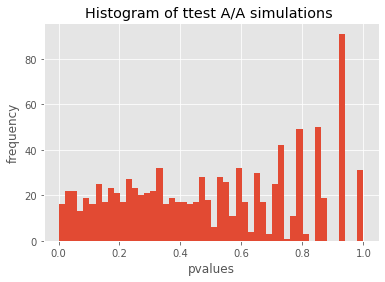

0.048

In [16]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df_upd[df_upd.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df_upd[df_upd.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

In [17]:
# как видим, FRP < 0.05 - мы нашли поломку.